# Compare Different MCMC Methods

The following output path will serve as folder for Julia results. As emphasized in the paper, the computation in the main results are done in Julia but visualized in R. The MAIN RESULTS folder below will accomodate the Julia output which will be imported to R for visualization.

In [1]:
out_path = joinpath(homedir(), "Dropbox/MS THESIS/R/MAIN RESULTS");

In [1]:
using Distributions: pdf, rand, Uniform, Normal
using DataFrames: DataFrame, nrow, writetable, stack, unstack
using Gadfly
using RDatasets
using StatsBase: autocor
using StochMCMC

Gadfly.push_theme(:dark)

## 1 Functions
The following imports the MCMC functions needed for later computations.

In [3]:
include(joinpath(homedir(), "Dropbox/MS THESIS/JULIA/MH.jl"));
include(joinpath(homedir(), "Dropbox/MS THESIS/JULIA/Gibbs.jl"));
include(joinpath(homedir(), "Dropbox/MS THESIS/JULIA/HMC.jl"));
include(joinpath(homedir(), "Dropbox/MS THESIS/JULIA/SG HMC.jl"));

## 2 Bayesian Linear Regression

<h2 style = "color:orange; font-family:Georgia;">A. Sample Size: 10</h2>

In [11]:
srand(123);
w0 = -.3; w1 = -.5; stdev = 5.;

"""
Define Data Parameters:
"""
# Precision
α = 1 / stdev; 

# Generate Hypothetical Data
n = 200;
x = rand(Uniform(-1, 1), n);
A = [ones(length(x)) x];
B = [w0; w1];
f = A * B;
y = f + rand(Normal(0, α), n);

"""
Define Hyperparameters
"""
Imat = eye(2);
β = 2.;
β1 = (1 / β)^2; # Square this since in Julia, Normal() uses standard dev

μ = zeros(2); # prior hyperparameter for mean
s = Imat; # prior hyperparameter for standard deviation

xy_df = DataFrame(X = x, Y = y);
burn_in = 1000;

# Hyperparameters
zero_vec = zeros(2)
eye_mat = eye(2)
a =  1 / 5.

0.2

In [30]:
(1 / β)^2; # Square this since in Julia, Normal() uses standard dev

0.25

In [ ]:
a =  1 / 5.

# Hyperparameters
zero_vec = zeros(2)
eye_mat = eye(2)


Imat = eye(2);
β = 2.;
β1 = (1 / β)^2; # Square this since in Julia, Normal() uses standard dev

μ = zeros(2); # prior hyperparameter for mean
s = β1 * Imat; # prior hyperparameter for standard deviation

xy_df = DataFrame(X = x, Y = y);
burn_in = 1000;

In [7]:
"""
The log likelihood function is given by the following codes:
"""
function loglike(theta::Array{Float64}; alpha::Float64 = α, x::Array{Float64} = x, y::Array{Float64} = y)
  yhat = theta[1] + theta[2] * x

  likhood = Float64[]
  for i in 1:length(yhat)
        push!(likhood, log(pdf(Normal(yhat[i], alpha), y[i])))
  end

  return likhood |> sum
end

"""
Define the logprior and logposterior
"""
function logprior(theta::Array{Float64}; mu::Array{Float64} = zero_vec, s::Array{Float64} = eye_mat)
  w0_prior = log(pdf(Normal(mu[1, 1], s[1, 1]), theta[1]))
  w1_prior = log(pdf(Normal(mu[2, 1], s[2, 2]), theta[2]))
   w_prior = [w0_prior w1_prior]

  return w_prior |> sum
end

function logpost(theta::Array{Float64})
    loglike(theta, alpha = a, x = x, y = y) + logprior(theta, mu = zero_vec, s = eye_mat)
end

Potential(theta::Array{Float64}) = - logpost(theta)

Kinetic(p::Array{Float64}; Σ = eye(length(p))) = (p' * inv(Σ) * p) / 2

function dPotential(theta::Array{Float64}; alpha::Float64 = 1/5., b::Float64 = 2.)
  [-alpha * sum(y - (theta[1] + theta[2] * x));
   -alpha * sum((y - (theta[1] + theta[2] * x)) .* x)] + b * theta
end

function dPotential_noise(theta::Array{Float64}; alpha::Float64 = 1/5., b::Float64 = 2.)
  [-alpha * sum(y - (theta[1] + theta[2] * x));
   -alpha * sum((y - (theta[1] + theta[2] * x)) .* x)] + b * theta + randn(2, 1)
end

dKinetic(p::AbstractArray{Float64}; Σ::Array{Float64} = eye(length(p))) = inv(Σ) * p;

### 2.1 Metropolis-Hasting

In [12]:
mh_object = MH(logpost);
@time chain1 = mcmc(mh_object, r = 10000);

  0.514974 seconds (643.50 k allocations: 170.017 MB, 4.67% gc time)


In [13]:
mapslices(mean, chain1, [1])

1×2 Array{Float64,2}:
 -0.307414  -0.500184

In [6]:
mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])

1×2 Array{Float64,2}:
 -0.306705  -0.502

In [20]:
xy_df_mh = xy_df;

In [21]:
xy_df_mh[:Yhat] = mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])[1] + mapslices(mean, chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), :], [1])[2] * xy_df[:X];

In [22]:
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_mh[Symbol("Yhat_Sample_" * string(i))] = chain1[i, 1] + chain1[i, 2] * xy_df_mh[:X]
end

In [23]:
xy_stack_mh = DataFrame(X = repeat(Array(xy_df_mh[:X]), outer = 3000), 
                        Y = repeat(Array(xy_df_mh[:Y]), outer = 3000),
                        Var = Array(stack(xy_df_mh[:, 4:end])[1]),
                        Val = Array(stack(xy_df_mh[:, 4:end])[2]));

In [24]:
ch1cor_df = DataFrame(x = collect(0:1:(length(autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 1])) - 1)), 
                      y1 = autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 1]),
                      y2 = autocor(chain1[Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000)), 2]));

In [25]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"));
p1 = plot(DataFrame(chain1), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"));
p2 = plot(DataFrame(chain1), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"));
p3 = plot(DataFrame(chain1), x = collect(1:nrow(DataFrame(chain1))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"));
p4 = plot(DataFrame(chain1), x = collect(1:nrow(DataFrame(chain1))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"));
p5 = plot(DataFrame(chain1), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"));
p6 = plot(layer(xy_df_mh, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_stack_mh, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          layer(xy_df_mh, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"));
p7 = plot(ch1cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 36, ymin = -.05, ymax = 1.05));
p8 = plot(ch1cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 36, ymin = -.05, ymax = 1.05));

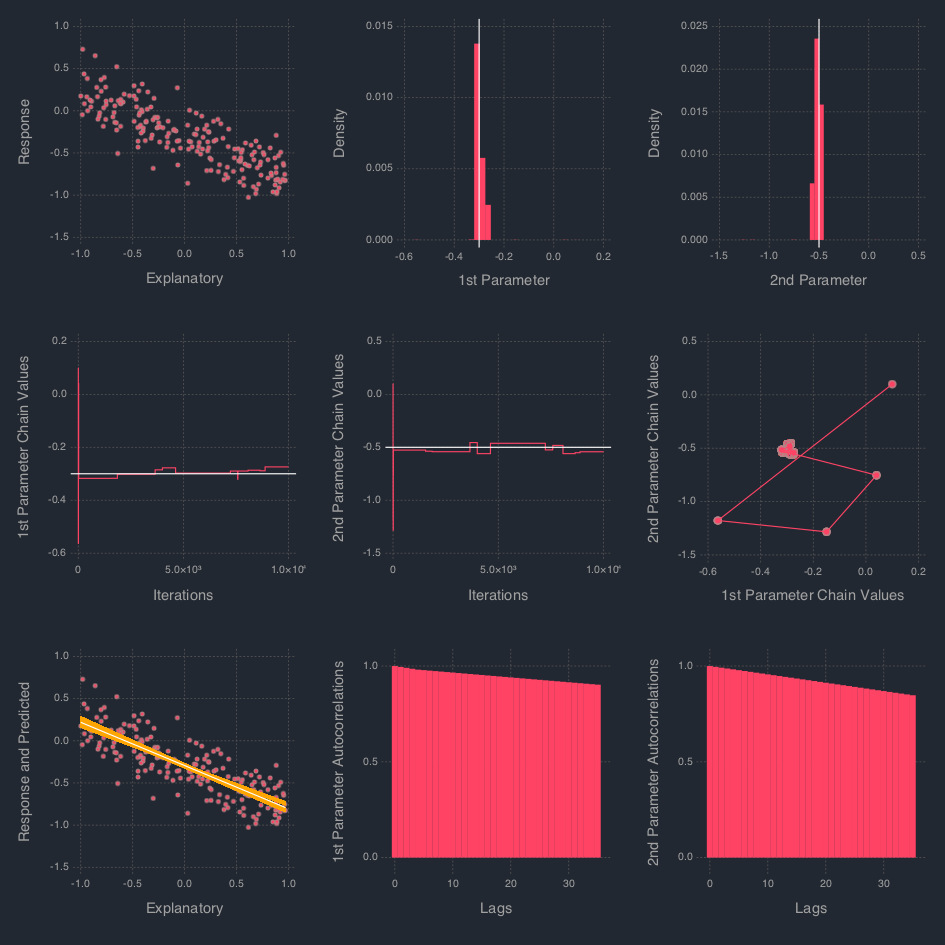

In [26]:
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))

### 2.3 Hamiltonian Monte Carlo

In [27]:
hmc_object = HMC(Potential, Kinetic, dPotential, dKinetic, zeros(2, 1), 2);
@time chain3 = mcmc(hmc_object, r = 10000);

 11.246102 seconds (19.96 M allocations: 5.539 GB, 9.13% gc time)


In [28]:
mapslices(mean, chain3, [1])

1×2 Array{Float64,2}:
 -0.297007  -0.509237

In [29]:
xy_df_hmc = xy_df;

In [ ]:
xy_df_hmc[:Yhat] = mapslices(mean, chain3, [1])[1] + mapslices(mean, chain3, [1])[2] * xy_df_hmc[:X];

In [ ]:
burn_in = 1000
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_hmc[Symbol("Yhat_Sample_" * string(i))] = chain3[i, 1] + chain3[i, 2] * xy_df_hmc[:X]
end

In [ ]:
xy_stack_hmc = DataFrame(X = repeat(Array(xy_df_hmc[:X]), outer = 3000), 
                         Y = repeat(Array(xy_df_hmc[:Y]), outer = 3000),
                         Var = Array(stack(xy_df_hmc[:, 4:end])[1]),
                         Val = Array(stack(xy_df_hmc[:, 4:end])[2]));

In [ ]:
ch3cor_df = DataFrame(x = collect(0:1:(length(autocor(chain3[:, 1])) - 1)), 
                      y1 = autocor(chain3[:, 1]),
                      y2 = autocor(chain3[:, 2]));

In [ ]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"));
p1 = plot(DataFrame(chain3), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"));
p2 = plot(DataFrame(chain3), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"));
p3 = plot(DataFrame(chain3), x = collect(1:nrow(DataFrame(chain3))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"));
p4 = plot(DataFrame(chain3), x = collect(1:nrow(DataFrame(chain3))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"));
p5 = plot(DataFrame(chain3), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"));
p6 = plot(layer(xy_df_hmc, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_stack_hmc, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          layer(xy_df_hmc, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"));
p7 = plot(ch3cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05));
p8 = plot(ch3cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05));

In [ ]:
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))

### 2.4 Stochastic Gradient Hamiltonian Monte Carlo

In [ ]:
SGHMC_object = SGHMC(dPotential_noise, dKinetic, eye(2), eye(2), eye(2), [0; 0], 2.);
@time chain4 = mcmc(SGHMC_object, r = 10000)#, leapfrog_params = Dict([:ɛ => .009, :τ => 20]));

In [ ]:
chain4[any(isnan(chain4), 2), :]

In [ ]:
chain4[~isnan(chain4[:, 1]), :]

In [ ]:
mapslices(mean, chain4, [1])

In [ ]:
xy_df_sghmc = xy_df;

In [ ]:
xy_df_sghmc[:Yhat] = mapslices(mean, chain3, [1])[1] + mapslices(mean, chain3, [1])[2] * xy_df_sghmc[:X];

In [ ]:
burn_in = 1000
for i in Array{Int64}(collect((burn_in + 1):((10000 - burn_in) / 3000):10000))
    xy_df_sghmc[Symbol("Yhat_Sample_" * string(i))] = chain4[i, 1] + chain4[i, 2] * xy_df_sghmc[:X]
end

In [ ]:
xy_stack_sghmc = DataFrame(X = repeat(Array(xy_df_sghmc[:X]), outer = 3000), 
                           Y = repeat(Array(xy_df_sghmc[:Y]), outer = 3000),
                           Var = Array(stack(xy_df_sghmc[:, 4:end])[1]),
                           Val = Array(stack(xy_df_sghmc[:, 4:end])[2]));

In [ ]:
ch4cor_df = DataFrame(x = collect(0:1:(length(autocor(chain4[:, 1])) - 1)), 
                      y1 = autocor(chain4[:, 1]),
                      y2 = autocor(chain4[:, 2]));

In [ ]:
p0 = plot(xy_df, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm), Guide.xlabel("Explanatory"), Guide.ylabel("Response"));
p1 = plot(DataFrame(chain4), x = :x1, xintercept = [-.3], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("1st Parameter"), Guide.ylabel("Density"));
p2 = plot(DataFrame(chain4), x = :x2, xintercept = [-.5], Geom.vline(color = colorant"white"), Geom.histogram(bincount = 30, density = true), Guide.xlabel("2nd Parameter"), Guide.ylabel("Density"));
p3 = plot(DataFrame(chain4), x = collect(1:nrow(DataFrame(chain4))), y = :x1, yintercept = [-.3], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("1st Parameter Chain Values"));
p4 = plot(DataFrame(chain4), x = collect(1:nrow(DataFrame(chain4))), y = :x2, yintercept = [-.5], Geom.hline(color = colorant"white"), Geom.line, Guide.xlabel("Iterations"), Guide.ylabel("2nd Parameter Chain Values"));
p5 = plot(DataFrame(chain4), x = :x1, y = :x2, Geom.path, Geom.point, Guide.xlabel("1st Parameter Chain Values"), Guide.ylabel("2nd Parameter Chain Values"));
p6 = plot(layer(xy_df_sghmc, x = :X, y = :Yhat, Geom.line, style(default_color = colorant"white")),
          layer(xy_stack_sghmc, x = :X, y = :Val, group = :Var, Geom.line, style(default_color = colorant"orange")),
          layer(xy_df_sghmc, x = :X, y = :Y, Geom.point, style(default_point_size = .05cm)),
          Guide.xlabel("Explanatory"), Guide.ylabel("Response and Predicted"));
p7 = plot(ch4cor_df, x = :x, y = :y1, Geom.bar, Guide.xlabel("Lags"), Guide.ylabel("1st Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05));
p8 = plot(ch4cor_df, x = :x, y = :y2, Geom.bar,  Guide.xlabel("Lags"), Guide.ylabel("2nd Parameter Autocorrelations"), Coord.cartesian(xmin = -1, xmax = 41, ymin = -.05, ymax = 1.05));

In [ ]:
draw(PNG(25cm, 25cm), vstack(hstack(p0, p1, p2), hstack(p3, p4, p5), hstack(p6, p7, p8)))